<a href="https://colab.research.google.com/github/JulianEspinosaUrresti/ProyectoI-MIAA-2025/blob/main/Taller_2_AAIII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **1. Carga de Paquetes***

In [23]:
import pandas as pd
import numpy as np
from statsmodels.sandbox.stats.runs import runstest_1samp # prueba de rachas de Wald y Wolfowitz
import statsmodels.api as sm # prueba de Box-Pierce y la modificación de Ljung-Box
from matplotlib import pyplot as plt # gráficos
import pylab as py
from scipy import stats
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error

### **2. Carga de Datos**

In [2]:
data = pd.read_excel("https://raw.githubusercontent.com/profedaniel86/Series_de_Tiempo/refs/heads/main/1.Intro/datosEmpleo.xlsx",index_col='mes',parse_dates=True)
data.head()

,TD_13ciudades,Ocupados,Desocupados,Inactivos
mes,,,,
2001-01-01,20.946380,6923.604,1834.507,4600.718
2001-02-01,19.894213,7037.746,1747.820,4596.805
2001-03-01,19.221565,6945.973,1652.823,4807.120
2001-04-01,17.888575,6973.079,1519.137,4937.280
2001-05-01,17.945654,6994.462,1529.720,4928.911


In [35]:
data.describe()

,TD_13ciudades,Ocupados,Desocupados,Inactivos,ocupados_lag1,ocupados_lag2
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,12.530807,9180.671800,1286.131291,5508.473577,9163.352464,9145.673391
std,2.718889,1284.443936,176.301551,381.302565,1287.543996,1291.485826
min,8.140713,6945.973000,857.491000,4614.088000,6945.973000,6923.604000
25%,10.394045,7980.720250,1152.180000,5310.788000,7971.477000,7970.166750
50%,11.869020,9149.522500,1268.917000,5535.068500,9139.064500,9115.132000
75%,14.072649,10470.268250,1396.901250,5755.005250,10439.022750,10423.498000
max,20.405924,11037.199000,1809.067000,6395.575000,11037.199000,11037.199000


In [42]:
data.dtypes

,0
TD_13ciudades,float64
Ocupados,float64
Desocupados,float64
Inactivos,float64
ocupados_lag1,float64
ocupados_lag2,float64


(222, 4)


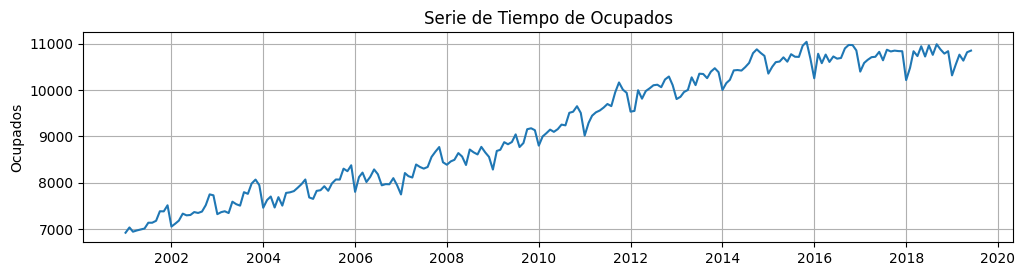

In [3]:
# imprimiendo el tamano del dataframe
print(data.shape)

# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Serie de Tiempo de Ocupados")
plt.ylabel("Ocupados")
plt.plot(data[["Ocupados"]])
plt.grid()

plt.show()

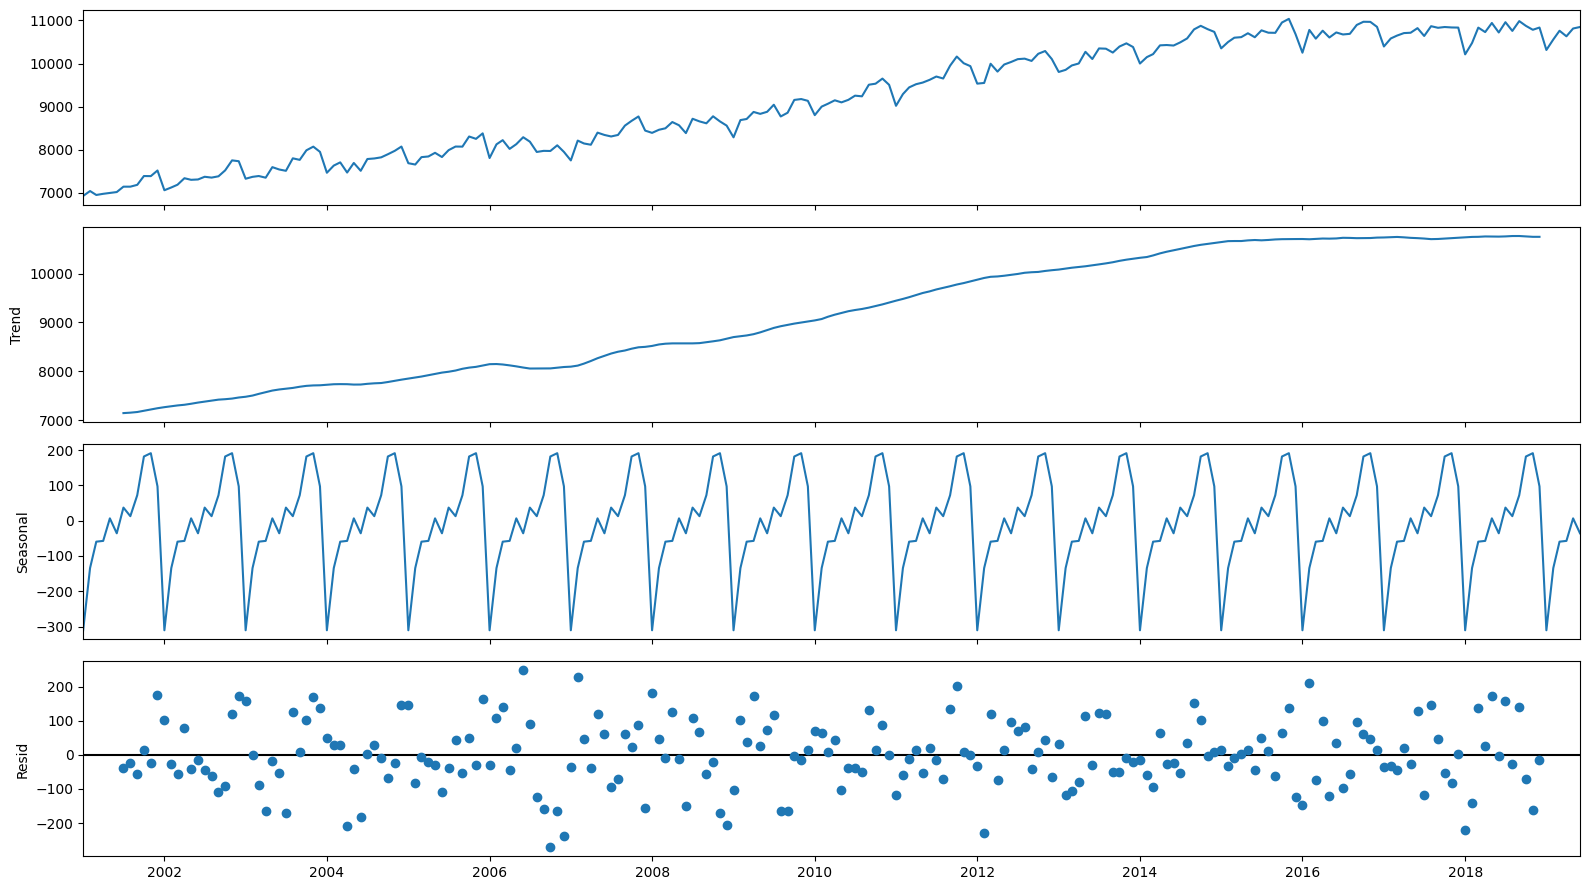

In [24]:
td_componentes = seasonal_decompose(data[["Ocupados"]],model="additive")
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

### **3. Autocorrelación**

Para determinar si existe autocorrelación usamos la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Las hipótesis son las siguientes:

H0:ρ=0  (Es decir no hay autocorrelación)

H1:ρ≠0  (Es decir hay autocorrelación)

Rechazo  H0  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α =0.05 ( α  = nivel de significancia).

In [4]:
signo = data.Ocupados>0

In [21]:
signo.value_counts()

,count
Ocupados,
True,222


In [20]:
runstest_1samp(signo, correction=False)

/usr/local/lib/python3.12/dist-packages/statsmodels/sandbox/stats/runs.py:102: RuntimeWarning: invalid value encountered in scalar divide
  z /= rstd


(np.float64(nan), np.float64(nan))

In [6]:
# prueba de Box-Pierce y la modificación de Ljung-Box
sm.stats.acorr_ljungbox(data.Ocupados, lags=[1], return_df=True,boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,215.466151,8.818153e-49,212.580444,3.757527e-48


Hay autocorrelación para el primer rezago.




In [7]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.Ocupados, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,215.466151,8.818153e-49,212.580444,3.757527e-48,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,425.045838,5.040446e-93,418.417636,1.386005e-91,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,629.973395,3.201138e-136,618.770917,8.590288e-134,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,830.534686,1.866623e-178,813.960031,7.268819e-175,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,1028.006530,5.191558e-220,1005.260880,4.364213e-215,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,1222.035167,8.145806e-261,1192.359923,2.155332e-254,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,1412.841689,6.426069e-301,1375.500111,7.718370e-293,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,1599.512253,0.000000e+00,1553.837168,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,1782.749605,0.000000e+00,1728.076257,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,1963.258217,0.000000e+00,1898.914764,0.000000e+00,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En el anterior data frame las columnas lb_ho y bp_ho nos permiten entender la decisión a tomar al usar las dos pruebas. Se puede concluir que la Si presenta autocorrelación.

### **4. Tendencia Lineal**

In [25]:
y = data["Ocupados"]
x = np.linspace(1,data.shape[0],data.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:               Ocupados   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     4729.
Date:                Sat, 08 Nov 2025   Prob (F-statistic):          1.02e-150
Time:                        16:15:45   Log-Likelihood:                -1559.9
No. Observations:                 222   AIC:                             3124.
Df Residuals:                     220   BIC:                             3131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6962.4958     36.871    188.835      0.0

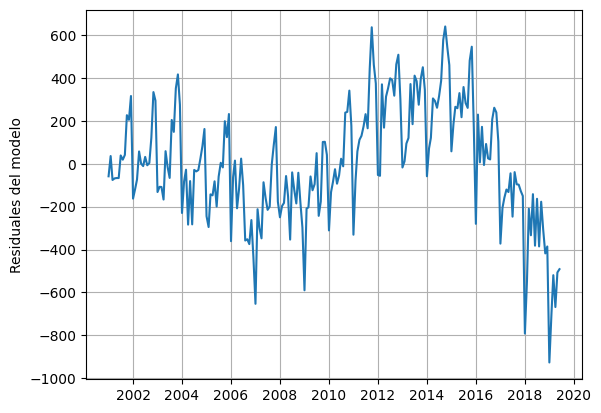

In [26]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

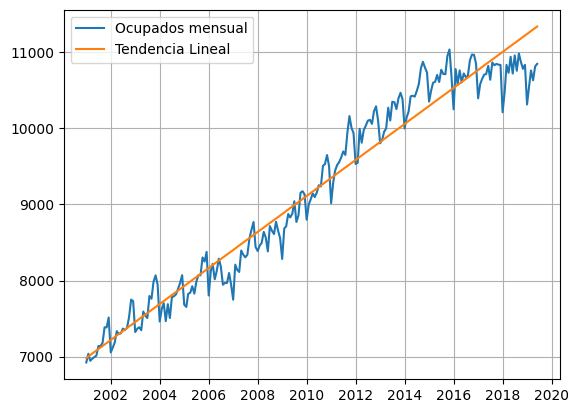

In [27]:
plt.plot(y,label="Ocupados mensual")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [49]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [50]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast      lower_95      upper_95
0    11122.613802  10578.969282  11666.258321
1    11142.330001  10598.626759  11686.033242
2    11162.046200  10618.283655  11705.808744
3    11181.762398  10637.939971  11725.584826
4    11201.478597  10657.595706  11745.361489
5    11221.194796  10677.250861  11765.138732


In [64]:
# Últimos 6 valores reales
y_real_6 = data["Ocupados"].iloc[-6:].values

# Predicciones del modelo (los 6 pronósticos)
y_pred_6 = preds["Point_forecast"].values

# Cálculo del RMSE
rmse_6 = np.sqrt(mean_squared_error(y_real_6, y_pred_6))
print(f"RMSE de los últimos 6 meses: {rmse_6:.4f}")

# (Opcional) RMSE relativo en porcentaje
rmse_pct = (rmse_6 / np.mean(y_real_6)) * 100
print(f"Error relativo promedio: {rmse_pct:.2f}%")


RMSE de los últimos 6 meses: 539.7688
Error relativo promedio: 5.07%


min/max data: 2002-01-01 00:00:00 2019-06-01 00:00:00
Hay reales 2019-01..2019-06?: True
preds.index (antes): <class 'pandas.core.indexes.datetimes.DatetimeIndex'> MS
DatetimeIndex(['2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01',
               '2019-05-01', '2019-06-01'],
              dtype='datetime64[ns]', freq='MS')
RMSE Ene–Jun 2019: 539.77


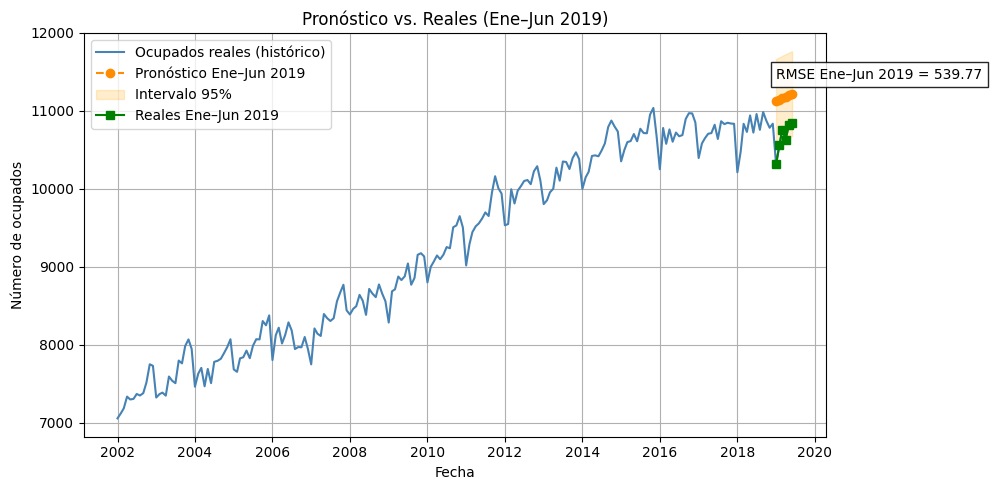

In [77]:
# --- DIAGNÓSTICO RÁPIDO ---
print("min/max data:", data.index.min(), data.index.max())
print("Hay reales 2019-01..2019-06?:", not data.loc['2019-01':'2019-06'].empty)
print("preds.index (antes):", type(preds.index), getattr(preds.index, "freqstr", None))
print(preds.index)   # verás que no son 2019-01..2019-06

# --- ARREGLO: fechar preds exactamente en Ene–Jun 2019 ---
import pandas as pd
h = len(preds)
target_idx = pd.date_range('2019-01-01', periods=h, freq='MS')  # Ene..Jun 2019
preds = preds.copy()
preds.index = target_idx

# --- EXTRAER REALES Y PREDICCIONES ENE–JUN 2019 ---
y_real_6 = data.loc['2019-01':'2019-06', 'Ocupados']
y_pred_6 = preds.loc['2019-01':'2019-06', 'Point_forecast']

# Si falta algún mes en data o preds, alineamos por intersección
common = y_real_6.index.intersection(y_pred_6.index)
y_real_6 = y_real_6.loc[common]
y_pred_6 = y_pred_6.loc[common]

# --- RMSE ---
from sklearn.metrics import mean_squared_error
import numpy as np

rmse_6 = np.sqrt(mean_squared_error(y_real_6, y_pred_6))
print(f"RMSE Ene–Jun 2019: {rmse_6:.2f}")

# --- GRÁFICO ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(data.index, data['Ocupados'], label='Ocupados reales (histórico)', color='steelblue')
plt.plot(preds.index, preds['Point_forecast'], '--o', color='darkorange', label='Pronóstico Ene–Jun 2019')

if {'lower_95','upper_95'}.issubset(preds.columns):
    plt.fill_between(preds.index, preds['lower_95'], preds['upper_95'], alpha=0.2, color='orange', label='Intervalo 95%')

plt.plot(y_real_6.index, y_real_6.values, 'gs-', label='Reales Ene–Jun 2019')

y_top = max(data['Ocupados'].max(), getattr(preds['upper_95'], 'max', preds['Point_forecast'].max)())
plt.text(preds.index[0], y_top*0.97, f"RMSE Ene–Jun 2019 = {rmse_6:.2f}",
         bbox=dict(facecolor='white', alpha=0.85))

plt.title('Pronóstico vs. Reales (Ene–Jun 2019)')
plt.xlabel('Fecha'); plt.ylabel('Número de ocupados')
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

                Real  Predicho   Error  |Error|  % Error
2019-01-01  10314.44  11122.61 -808.18   808.18    -7.84
2019-02-01  10557.92  11142.33 -584.41   584.41    -5.54
2019-03-01  10760.78  11162.05 -401.27   401.27    -3.73
2019-04-01  10632.03  11181.76 -549.73   549.73    -5.17
2019-05-01  10813.00  11201.48 -388.48   388.48    -3.59
2019-06-01  10848.00  11221.19 -373.19   373.19    -3.44

RMSE Ene–Jun 2019: 539.77
MAPE Ene–Jun 2019: 4.88%


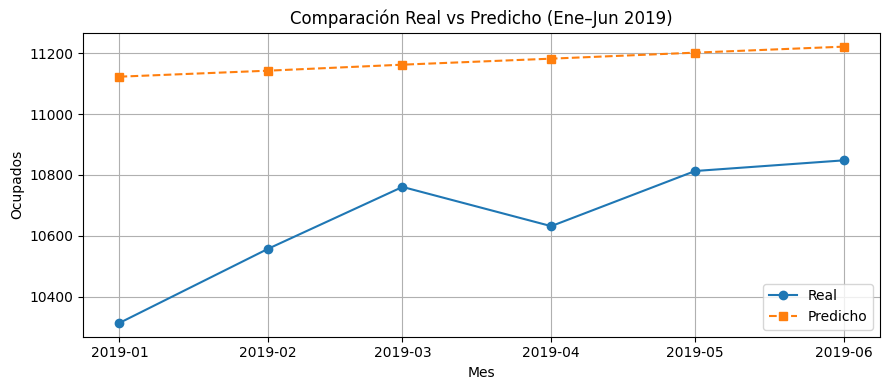

In [78]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# --- Rango objetivo: Ene–Jun 2019 ---
target_idx = pd.date_range('2019-01-01', periods=6, freq='MS')

# Asegura que tus pronósticos (preds) estén fechados en Ene–Jun 2019
# (omítelo si ya lo hiciste antes)
preds = preds.copy()
preds.index = target_idx   # <-- si tus preds son exactamente 6 filas

# Extrae reales y pronosticados
y_real = data.loc[target_idx, 'Ocupados']
y_pred = preds.loc[target_idx, 'Point_forecast']

# Alinea por intersección por si faltara algún mes
common = y_real.index.intersection(y_pred.index)
y_real = y_real.loc[common]
y_pred = y_pred.loc[common]

# --- Tabla comparativa ---
cmp = pd.DataFrame({
    'Real': y_real,
    'Predicho': y_pred
}, index=common)

cmp['Error'] = cmp['Real'] - cmp['Predicho']
cmp['|Error|'] = cmp['Error'].abs()
cmp['% Error'] = 100 * cmp['Error'] / cmp['Real']

# Métricas
rmse = np.sqrt(mean_squared_error(cmp['Real'], cmp['Predicho']))
mape = (cmp['|Error|'] / cmp['Real']).mean() * 100

print(cmp.round(2))
print(f"\nRMSE Ene–Jun 2019: {rmse:.2f}")
print(f"MAPE Ene–Jun 2019: {mape:.2f}%")

# --- Gráfico rápido de comparación ---
plt.figure(figsize=(9,4))
plt.plot(cmp.index, cmp['Real'], marker='o', label='Real')
plt.plot(cmp.index, cmp['Predicho'], marker='s', linestyle='--', label='Predicho')
plt.title('Comparación Real vs Predicho (Ene–Jun 2019)')
plt.xlabel('Mes'); plt.ylabel('Ocupados'); plt.grid(True); plt.legend()
plt.tight_layout(); plt.show()

In [69]:
y_real = y
y_prd = lin_t.fittedvalues

# Cálculo del RMSE
rmse = np.sqrt(mean_squared_error(y_real, y_prd))
print(f"RMSE del modelo: {rmse:.4f}")

RMSE del modelo: 272.5181


=== Métricas pseudo-OOS sobre los últimos h meses ===
RMSE : 725.53
MAE  : 709.30
MAPE : 6.68%
Cobertura IC95%: 0.00%
Ancho promedio IC95: 1,004.86



,Real,Predicho,lower_95,upper_95,Error,AbsError,SqError,PctError_%,Dentro_IC95
mes,,,,,,,,,
2019-01-01,10314.438,11313.116,10810.849,11815.384,-998.678,998.678,997358.430,-9.682,False
2019-02-01,10557.917,11333.335,10831.004,11835.667,-775.418,775.418,601273.449,-7.344,False
2019-03-01,10760.776,11353.554,10851.158,11855.950,-592.778,592.778,351385.925,-5.509,False
2019-04-01,10632.028,11373.773,10871.312,11876.234,-741.745,741.745,550185.707,-6.977,False
2019-05-01,10813.000,11393.992,10891.465,11896.519,-580.992,580.992,337551.637,-5.373,False
2019-06-01,10848.000,11414.211,10911.618,11916.804,-566.211,566.211,320594.718,-5.219,False


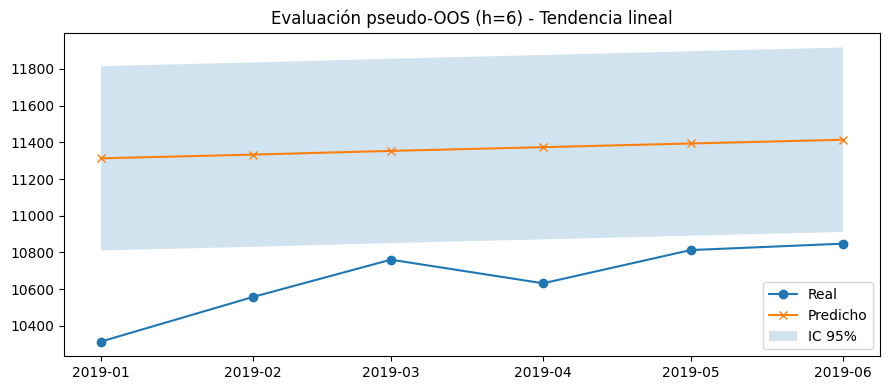

In [30]:
# ==== EVALUACIÓN PSEUDO-FUERA-DE-MUESTRA (tendencia lineal) ====
# Corta los últimos h meses, reentrena con el resto y evalúa esos h.

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Parámetros
h = 6  # horizonte a evaluar

# Serie original (como en tu notebook)
y_full = data["Ocupados"].copy()
idx_full = y_full.index

# Split: entrenamiento (todo menos los últimos h) y "test" (últimos h)
y_train = y_full.iloc[:-h]
y_test  = y_full.iloc[-h:]
idx_test = y_test.index

# === Modelo de tendencia lineal re-ajustado solo con entrenamiento ===
t_train = np.arange(1, len(y_train) + 1, dtype=float)
X_train = sm.add_constant(t_train)
lin_t_re = sm.OLS(y_train, X_train).fit()

# Matriz para pronosticar los últimos h meses (que ahora serán "futuros" respecto al train)
t_for = np.arange(len(y_train) + 1, len(y_train) + h + 1, dtype=float)
X_for  = sm.add_constant(t_for)

# Predicciones puntuales e IC 95%
dt = lin_t_re.get_prediction(X_for).summary_frame(alpha=0.05)
preds = dt[['mean', 'obs_ci_lower', 'obs_ci_upper']].rename(
    columns={'mean': 'Predicho', 'obs_ci_lower': 'lower_95', 'obs_ci_upper': 'upper_95'}
)
preds.index = idx_test  # fechas reales de los últimos h meses

# Comparación Real vs Predicho
comparacion = pd.concat(
    [y_test.rename("Real"), preds[['Predicho','lower_95','upper_95']]], axis=1
)
comparacion["Error"] = comparacion["Real"] - comparacion["Predicho"]
comparacion["AbsError"] = comparacion["Error"].abs()
comparacion["SqError"]  = comparacion["Error"]**2
comparacion["PctError_%"] = (comparacion["Error"] / comparacion["Real"]) * 100
comparacion["Dentro_IC95"] = (
    (comparacion["Real"] >= comparacion["lower_95"]) &
    (comparacion["Real"] <= comparacion["upper_95"])
)

# Métricas
RMSE = float(np.sqrt(comparacion["SqError"].mean()))
MAE  = float(comparacion["AbsError"].mean())
MAPE = float((comparacion["AbsError"]/comparacion["Real"]).mean()*100)
coverage_95 = float(comparacion["Dentro_IC95"].mean()*100)
avg_ic_width = float((comparacion["upper_95"] - comparacion["lower_95"]).mean())

print("=== Métricas pseudo-OOS sobre los últimos h meses ===")
print(f"RMSE : {RMSE:,.2f}")
print(f"MAE  : {MAE:,.2f}")
print(f"MAPE : {MAPE:.2f}%")
print(f"Cobertura IC95%: {coverage_95:.2f}%")
print(f"Ancho promedio IC95: {avg_ic_width:,.2f}\n")

# Tabla
display(comparacion.round(3))

# (Opcional) Gráfica
plt.figure(figsize=(9,4))
plt.plot(comparacion.index, comparacion["Real"], marker="o", label="Real")
plt.plot(comparacion.index, comparacion["Predicho"], marker="x", label="Predicho")
plt.fill_between(comparacion.index, comparacion["lower_95"], comparacion["upper_95"], alpha=0.2, label="IC 95%")
plt.title(f"Evaluación pseudo-OOS (h={h}) - Tendencia lineal")
plt.legend()
plt.tight_layout()
plt.show()

### **4. Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante)

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [8]:
sm.stats.acorr_ljungbox((data.Ocupados-data.Ocupados.mean())**2, lags=range(1,21), return_df=True,boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,185.144285,3.650054e-42,182.664674,1.269512e-41
2,351.726827,4.202327e-77,346.272528,6.425041e-76
3,503.667333,7.654204e-109,494.821504,6.322880e-107
4,644.388355,3.822171e-138,631.773213,2.056334e-135
5,779.932738,2.537066e-166,763.081835,1.120126e-162
6,908.018395,6.939421e-193,886.593004,2.972305e-188
7,1033.010933,8.866253e-219,1006.563521,4.598527e-213
8,1150.214310,5.463849e-243,1118.534603,3.804834e-236
9,1265.945521,6.998913e-267,1228.582585,8.181347e-259
10,1382.954411,4.749866e-291,1339.323142,1.245900e-281


### **5. Normalidad**


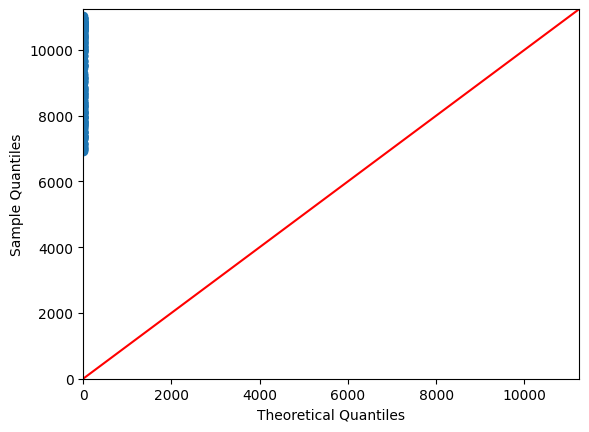

In [9]:
sm.qqplot(data.Ocupados, line ='45')
py.show()

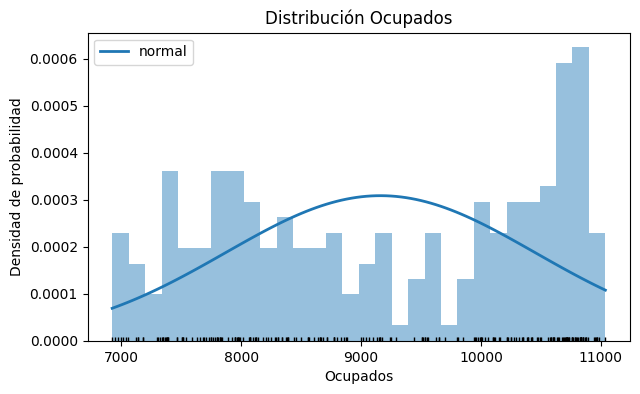

In [10]:
# Histograma + curva normal teórica
# ==============================================================================

# Valores de la media (mu) y desviación típica (sigma) de los datos
mu, sigma = stats.norm.fit(data.Ocupados)

# Valores teóricos de la normal en el rango observado
x_hat = np.linspace(min(data.Ocupados), max(data.Ocupados), num=100)
y_hat = stats.norm.pdf(x_hat, mu, sigma)

# Gráfico
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(x_hat, y_hat, linewidth=2, label='normal')
ax.hist(x=data.Ocupados, density=True, bins=30, color="#3182bd", alpha=0.5)
ax.plot(data.Ocupados, np.full_like(data.Ocupados, 0.000), '|k', markeredgewidth=1)
ax.set_title('Distribución Ocupados')
ax.set_xlabel('Ocupados')
ax.set_ylabel('Densidad de probabilidad')
ax.legend();

In [11]:
stats.shapiro(data.Ocupados)

ShapiroResult(statistic=np.float64(0.9111439682568433), pvalue=np.float64(3.039085379954234e-10))

In [12]:
stats.jarque_bera(data.Ocupados)

SignificanceResult(statistic=np.float64(20.11813814008792), pvalue=np.float64(4.2795865091983345e-05))

KeyError: 'Point_forecast'

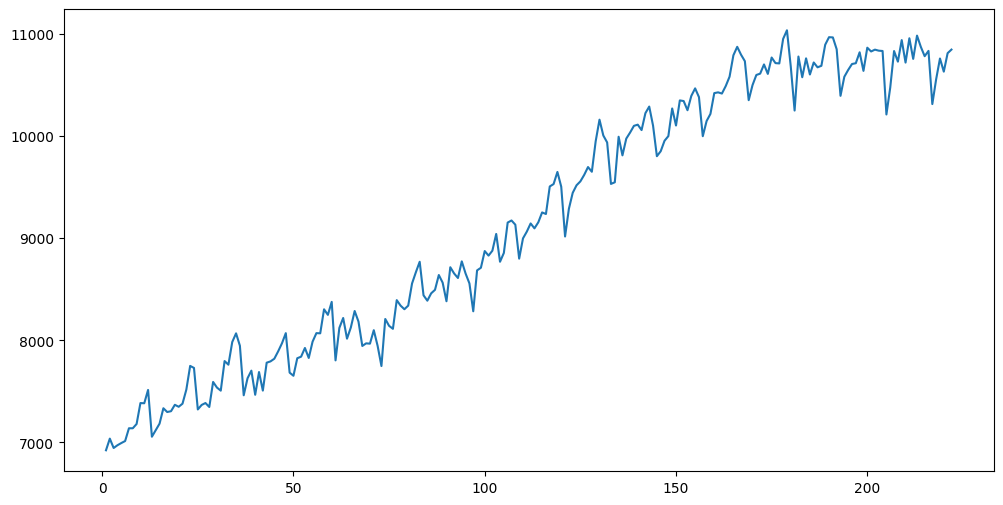

In [19]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **7. Tendencia Cuadratica**

In [ ]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2
X = sm.add_constant(data[["x","x2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

In [ ]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

In [ ]:
plt.plot(y,label="Ocupados Mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia Cuadratica")
plt.legend()
plt.grid()
plt.show()

In [ ]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [ ]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia Cuadrática")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **8. Estimación de la Estacionalidad**

In [ ]:
month_dummies = pd.get_dummies(data.index.month,drop_first=True, dtype=float).set_index(data.index)

y = data["Ocupados"]
X = sm.add_constant(month_dummies)
sea = sm.OLS(y,X)
season = sea.fit()
print(season.summary())

In [ ]:
plt.ylabel("Residuales del modelo")
plt.plot(season.resid)
plt.grid()

In [ ]:
plt.plot(y,label="Ocupados mensual")
plt.plot(season.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [ ]:
range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=6, freq='MS')

# Create month dummies for the future dates, ensuring all months are represented
x_for = pd.get_dummies(range_dates.month, dtype=float)
# Add a constant term
x_for = sm.add_constant(x_for, has_constant='add')

# Reindex the future month dummies to match the columns of the original training data
# This ensures that all month columns are present, even if a month is not in the future range
# and that the constant is in the correct position.
X_for = x_for.reindex(columns=X.columns, fill_value=0)

In [ ]:
dt = season.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)

In [ ]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.show()

### **9. Tendencia + Estacionalidad**

In [ ]:
y = data["Ocupados"]
data["x"] = np.linspace(1,data.shape[0],data.shape[0])
data["x2"] = x**2

month_dummies = pd.get_dummies(data.index.month,drop_first=True, dtype=float).set_index(data.index)
X = sm.add_constant( pd.concat([data[["x","x2"]],month_dummies],axis=1) )

season_pol2 = sm.OLS(y,X)
season_pol_2 = season_pol2.fit()
print(season_pol_2.summary())

In [ ]:
X

In [ ]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_2.resid)
plt.grid()

In [ ]:
plt.plot(y,label="Tasa Ocupados Mensual")
plt.plot(season_pol_2.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [ ]:
h=6
x_for= np.linspace((data.shape[0]+1),(data.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2),axis=1),columns=["x","x2"] )

range_dates = pd.date_range(data.index[-1]+ relativedelta(months=1), periods=h,freq='MS')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True, dtype=float)

X_for= pd.concat([x_for_all,x_for_dummies],axis=1)
X_for = sm.add_constant(X_for, has_constant='add')

# Reindex X_for to match the columns of the original training data X
X_for = X_for.reindex(columns=X.columns, fill_value=0)

In [ ]:
dt = season_pol_2.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds)